$$\newcommand{\Rv}{\mathbf{R}}
\newcommand{\rv}{\mathbf{r}}
\newcommand{\Qv}{\mathbf{Q}}
\newcommand{\Qnv}{\mathbf{Qn}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\Aiv}{\mathbf{Ai}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\TDv}{\mathbf{TD}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

# Reinforcement Learning Modular Framework

Let's assemble much of the code from Lecture 18 into several classes.  This will clearly separate the environment from the agent in a reinforcement learning setting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks_A4 as nn   # from A4

from IPython.display import display, clear_output

First, we define two classes that just define the functions we need to define an `Environment` and an `Agent`. The latest versions of python let us declare abstract classes and methods.

In [2]:
from abc import ABC, abstractmethod
    
class Environment(ABC):
    
    def __init__(self, valid_actions):
        self.valid_actions = valid_actions

    @abstractmethod
    def initial_state(self):
        return state  # the initial state
    
    @abstractmethod
    def next_state(self, state, action):
        return next_state  
    
    @abstractmethod
    def reinforcement(self, state):
        return r # scalar reinforcement
   
    def terminal_state(self, state):
        return False  # True if state is terminal state

If abstract methods are not defined in a class derived from `Environment`, we cannot instantiate an instance of that class.

In [3]:
class Marble(Environment):
    
    def reinforcement(self, state):
        return 1

In [4]:
m = Marble()

TypeError: Can't instantiate abstract class Marble with abstract methods initial_state, next_state

In [5]:
class Marble(Environment):

    def __init__(self, valid_actions):
        super().__init__(valid_actions)
        
    def initial_state(self):
        return np.array([10 * np.random.uniform(), 0.0])

    def next_state(self, state, action):
        '''[0] is position, s[1] is velocity. a is -1, 0 or 1'''    
        next_state = state.copy()
        deltaT = 0.1                           # Euler integration time step
        next_state[0] += deltaT * state[1]                  # Update position
        force = action
        mass = 0.5
        next_state[1] += deltaT * (force / mass - 0.2 * state[1])  # Update velocity. Includes friction

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] < 0:        
            next_state = [0., 0.]    # these constants as ints were causing the errors we discussed in class. I DON'T KNOW WHY!!
        elif next_state[0] > 10:
            next_state = [10., 0.]

        return next_state

    def reinforcement(self, state):
        goal = 5
        return 0 if abs(state[0]- goal) < 1 else -1

    def terminal_state(self, state):
        return False

In [6]:
marble = Marble(np.array([-1, 0, 1]))

Now we can define an abstract class for a generic `Agent`.

In [7]:
class Agent(ABC):
    
    def __init__(self, environment):
        self.environment = environment

    @abstractmethod
    def make_samples(self, n_samples, epsilon):
        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def epsilon_greedy(self, state, epsilon):
        valid_actions = self.environment.valid_actions

        if np.random.uniform() < epsilon:
            # Random Move
            action = np.random.choice(valid_actions)
        else:
            # Greedy Move
            Qs = [self.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
            ai = np.argmax(Qs)
            action = valid_actions[ai]

        return action

    @abstractmethod
    def train(self):
        return

    @abstractmethod
    def use(self, X):
        return # Q values for each row of X, each consisting of state and action

In [8]:
class Qnet(Agent):

    def __init__(self, environment, hidden_layers, X_means=None, X_stds=None, Q_means=None, Q_stds=None):
        self.environment = environment
        state_size = environment.initial_state().size  # assumes state is an np.array
        valid_actions = environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        self.Qnet = nn.NeuralNetwork(state_size + action_size, hidden_layers, 1)
        if X_means:
            self.Qnet.X_means = np.array(X_means)
            self.Qnet.X_stds = np.array(X_stds)
            self.Qnet.T_means = np.array(Q_means)
            self.Qnet.T_stds = np.array(Q_stds)

    def make_samples(self, n_samples, epsilon):
 
        state_size = self.environment.initial_state().size  # assumes state is an np.array
        valid_actions = self.environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        X = np.zeros((n_samples, state_size + action_size))
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool)  # All False values

        state = self.environment.initial_state()
        state = self.environment.next_state(state, 0)        # Update state, sn from s and a
        action = self.epsilon_greedy(state, epsilon)

        # Collect data from n_samples steps
        for step in range(n_samples):

            next_state = self.environment.next_state(state, action)        # Update state, sn from s and a
            r = self.environment.reinforcement(state)   # Calculate resulting reinforcement
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = r
            if self.environment.terminal_state(state):
                terminal_state[step, 0] = True
                Qn[step, 0] = 0
            else:
                Qn[step, 0] = self.use(np.hstack((next_state, next_action)))
            # Advance one time step
            state, action = next_state, next_action

        return X, R, Qn, terminal_state

    def update_Qn(self, X, Qn, terminal_state):
        n_samples = X.shape[0]
        for i in range(n_samples - 1):
            if not terminal_state[i+1]:
                Qn[i] = self.use(X[i+1])
        return Qn

    def train(self, n_trials, n_steps_per_trial, n_epochs, method, learning_rate, 
              gamma, epsilon, final_epsilon,
              trial_callback=None):

        if trial_callback:
            fig = plt.figure(figsize=(10, 10))
            
        epsilon_decay =  np.exp(np.log(final_epsilon) / n_trials) # to produce this final value
        print('epsilon_decay is', epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)

        for trial in range(n_trials):

            X, R, Qn, terminal_state = self.make_samples(n_steps_per_trial, epsilon)

            for epoch in range(n_epochs):
                self.Qnet.train(X, R + gamma * Qn, 1,  method=method, learning_rate=learning_rate, batch_size=-1, verbose=False)
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay

            # Rest is for plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (trial + 1 == n_trials or trial % (n_trials / 50) == 0):
                fig.clf()
                trial_callback(agent, trial, n_trials, X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)

        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)

In [9]:
from matplotlib import cm

def plot_status(agent, trial, n_trials, X, epsilon_trace, r_trace):
    

    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
               
    plt.subplot(3, 3, 2)
    plt.plot(r_trace[:trial + 1], alpha=0.5)
    plt.ylabel('Mean reinforcement')
        
    valid_actions = agent.environment.valid_actions

    qs = agent.use(np.array([[s, 0, a] for a in valid_actions for s in range(11)]))
               
    plt.subplot(3, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2,'Policy for Zero Velocity')
    plt.axis('off')
               
               
    plt.subplot(3, 3, 4)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = agent.use(np.array([[xsflat[i], ysflat[i], a] for a in valid_actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(valid_actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax, 20, cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
               
    plt.subplot(3, 3, 5)
    acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    plt.subplot(3, 3, 6)
    plt.plot(X[:, 0], X[: ,1])
    plt.plot(X[-1, 0], X[-1, 1], 'ro')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([4, 6], [-5, -5], [5, 5], color='red', alpha=0.3)  # CHECK OUT THIS FUNCTION!
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.title('Last Trial')

    ax = plt.subplot(3, 3, 7, projection='3d')
    ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap=cm.coolwarm)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    ax = plt.subplot(3, 3, 8, projection='3d')
    ax.plot_surface(xs, ys, acts, cmap=cm.coolwarm, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    test_it(agent, 10, 500)

    plt.tight_layout()

def test_it(agent, n_trials, n_steps_per_trial):
    xs = np.linspace(0, 10, n_trials)
    plt.subplot(3, 3, 9) 
    
    # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
    for x in xs:
        
        s = [x, 0]  # 0 velocity
        x_trace = np.zeros((n_steps_per_trial, 2))
        for step in range(n_steps_per_trial):
            a = agent.epsilon_greedy(s, 0.0) # epsilon = 0
            s = agent.environment.next_state(s, a)
            x_trace[step, :] = s
            
        plt.plot(x_trace[:, 0], x_trace[:, 1])
        plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
        plt.fill_between([4, 6], [-5, -5], [5, 5], color='pink', alpha=0.3)
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')


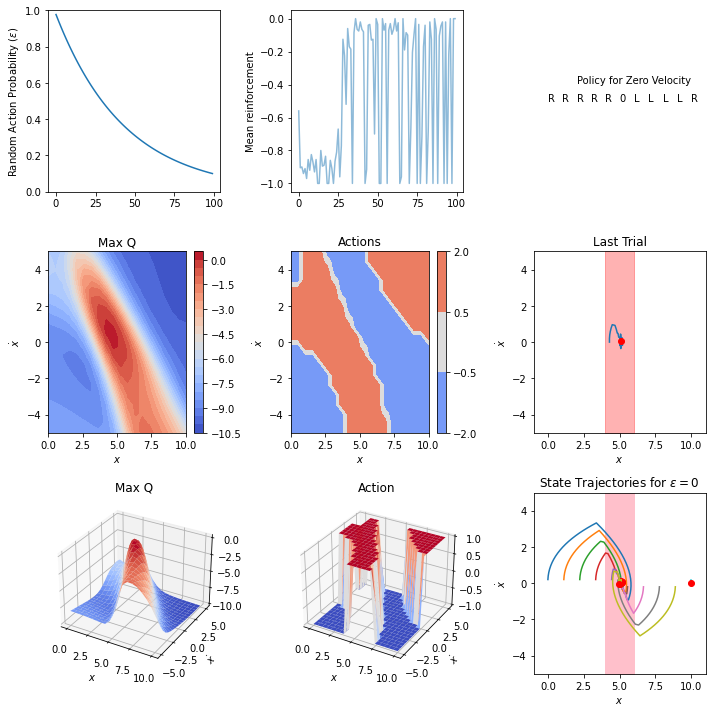

In [18]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[10, 10],
              X_means=[5, 0, 0], X_stds=[2, 2, 0.8],
              Q_means=[-2], Q_stds=[1])

plt.ion()

epsilon_trace, r_trace =  agent.train(n_trials=100, n_steps_per_trial=200, n_epochs=500,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.1,
                                      trial_callback=plot_status)